<a href="https://colab.research.google.com/github/Sreerag-Pillai/Data_Science/blob/main/econ_metrics_stock_prices_analysis_stat_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install pandas numpy matplotlib seaborn yfinance
!pip install fredapi

Real Disposable Personal Income (DSPIC96)
https://fred.stlouisfed.org/series/DSPIC96
Real Disposable Personal Income (DSPIC96) is a measure of the total income available to households after taxes and inflation. It is calculated by taking Personal Income (PI) and subtracting personal income taxes and other government transfer payments, then adjusting for inflation using the Chained Price Index for Personal Consumption Expenditures (PCE).

DSPIC96 is considered to be a good measure of the standard of living in the United States, as it takes into account both the amount of income that households have available to spend and the purchasing power of that income.


 Leading Indicators OECD: Reference Series: Gross Domestic Product (GDP): Normalised for United States (USALORSGPNOSTSAM)


In [ ]:
import pandas as pd
import yfinance as yf
from fredapi import Fred
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats


## Importing all the economic data using FRED api and excel files and merging it in to one df

GDP Data - S&P Monthly GDP DATA

https://www.spglobal.com/marketintelligence/en/mi/products/us-monthly-gdp-index.html

In [ ]:
# Load the Excel file without skipping any rows initially
gdp_data = pd.read_excel('US-Monthly-GDP-History-Data.xlsx')

# Display the first few rows of the DataFrame
#gdp_data.head()

# Rename 'Unnamed: 0' to 'Date'
gdp_data.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)

# Adjust the format of the 'Date' column to 'YYYY-MM'
gdp_data['Date'] = pd.to_datetime(gdp_data['Date']).dt.to_period('M').dt.strftime('%Y-%m')

# Display the first few rows to verify the changes
#gdp_data.head()

# Select only the 'Date' and 'Monthly Real GDP Index' columns
gdp_data = gdp_data[['Date', 'Monthly Real GDP Index']]

# Display the first few rows to verify the changes
gdp_data.head()

,Date,Monthly Real GDP Index
0,1992-01,10177.846961
1,1992-02,10222.867583
2,1992-03,10307.994072
3,1992-04,10314.362267
4,1992-05,10293.427959


Sovereign credit ratings USA (Fitch)

https://www.theglobaleconomy.com/USA/credit_rating/

In [ ]:
# Load the credit rating data
credit_rating_data = pd.read_excel('Credit_rating.xlsx')

# Convert the 'Date' column to 'YYYY-MM' format
credit_rating_data['Date'] = pd.to_datetime(credit_rating_data['Date']).dt.to_period('M').dt.strftime('%Y-%m')

# Sort the data by date
credit_rating_data.sort_values(by='Date', inplace=True)

# Drop the "Rating" column
credit_rating_data = credit_rating_data.drop(columns="Rating")

# Display the first few rows to verify the changes
credit_rating_data.head()


,Agency,Outlook,Date
36,Fitch,Negative,1995-11
35,Fitch,Stable,2000-09
34,Fitch,Stable,2011-09
33,Fitch,Stable,2011-11
32,Fitch,Negative,2011-12


In [ ]:
import pandas as pd
from datetime import datetime

# Assuming credit_rating_data is already loaded and processed

# Initialize an empty DataFrame to store the extended ratings
extended_ratings = pd.DataFrame()

# Set the initial rating
current_outlook = None

# Get the current month in 'YYYY-MM' format
current_month = datetime.now().strftime('%Y-%m')

# Iterate over each month from the earliest date in your dataset to the current month
for month in pd.date_range(start=credit_rating_data['Date'].min(), end=current_month, freq='M').strftime('%Y-%m'):
    # Check if there's a new rating for this month
    if month in credit_rating_data['Date'].values:
        current_outlook = credit_rating_data.loc[credit_rating_data['Date'] == month, 'Outlook'].iloc[0]

    # Append the current rating and outlook to the extended_ratings DataFrame
    extended_ratings = extended_ratings.append({'Date': month,  'Outlook': current_outlook}, ignore_index=True)


# Convert 'Date' column in extended_ratings to datetime for comparison
extended_ratings['Date'] = pd.to_datetime(extended_ratings['Date'])

# Filter extended_ratings to include only data from January 2000 onwards
extended_ratings = extended_ratings[extended_ratings['Date'] >= '2000-01']

# Convert 'Date' back to 'YYYY-MM' format after filtering
extended_ratings['Date'] = extended_ratings['Date'].dt.strftime('%Y-%m')

# Display the first few rows of the extended ratings
extended_ratings.head()


<ipython-input-6-900fb12b8454>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  extended_ratings = extended_ratings.append({'Date': month,  'Outlook': current_outlook}, ignore_index=True)
<ipython-input-6-900fb12b8454>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  extended_ratings = extended_ratings.append({'Date': month,  'Outlook': current_outlook}, ignore_index=True)
<ipython-input-6-900fb12b8454>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  extended_ratings = extended_ratings.append({'Date': month,  'Outlook': current_outlook}, ignore_index=True)
<ipython-input-6-900fb12b8454>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

,Date,Outlook
50,2000-01,Negative
51,2000-02,Negative
52,2000-03,Negative
53,2000-04,Negative
54,2000-05,Negative


Getting all other data from FRED

In [ ]:


# Initialize the FRED API client
fred = Fred(api_key='ffea35692a23cedbc71a3606d926393c')

# Fetch economic data from FRED
federal_fund_rate = fred.get_series('FEDFUNDS')  # Federal Funds Rate
cpi = fred.get_series('CORESTICKM159SFRBATL')  # Consumer Price Index
unemployment_rate = fred.get_series('UNRATE')  # Unemployment Rate
treasury_yield = fred.get_series('GS1')  # 1-Year Treasury Constant Maturity Rate
credit_card_debt = fred.get_series('CCSA')  # Consumer Credit Outstanding: Revolving Credit
median_household_income = fred.get_series('DSPIC96')  # Real Disposable Personal Income
Money_supply = fred.get_series('M1SL') # M1 money supply


# Create a DataFrame to store the economic data
economic_data = pd.DataFrame()

# Convert series index to datetime
for series in [federal_fund_rate, cpi, unemployment_rate, treasury_yield, credit_card_debt, median_household_income, Money_supply, gdp_data]:
    series.index = pd.to_datetime(series.index)

# Resample and forward-fill the data to ensure monthly frequency
federal_fund_rate_monthly = federal_fund_rate.resample('M').ffill()
cpi_monthly = cpi.resample('M').ffill()
unemployment_rate_monthly = unemployment_rate.resample('M').ffill()
treasury_yield_monthly = treasury_yield.resample('M').ffill()
credit_card_debt_monthly = credit_card_debt.resample('M').ffill()
median_household_income_monthly = median_household_income.resample('M').ffill()
Money_supply_monthly = Money_supply.resample('M').ffill()

# Combine the resampled series into the economic_data DataFrame
economic_data['Monthly Federal Funds Rate'] = federal_fund_rate_monthly
economic_data['Monthly CPI'] = cpi_monthly
economic_data['Monthly Unemployment Rate'] = unemployment_rate_monthly
economic_data['Monthly 10-Year Treasury Yield'] = treasury_yield_monthly
economic_data['Monthly Credit Card Debt'] = credit_card_debt_monthly
economic_data['Income']= median_household_income_monthly
economic_data['Money_supply_monthly'] = Money_supply_monthly

# Reset the index to have a 'Date' column
economic_data.reset_index(inplace=True)
economic_data.rename(columns={'index': 'Date'}, inplace=True)

# Filter the DataFrame to only include data from 2000 onwards
economic_data = economic_data[economic_data['Date'] >= '2000-01-01']

# Reset the index after filtering
economic_data.reset_index(drop=True, inplace=True)

# Display the head of the DataFrame to verify the output
economic_data.head()


,Date,Monthly Federal Funds Rate,Monthly CPI,Monthly Unemployment Rate,Monthly 10-Year Treasury Yield,Monthly Credit Card Debt,Income,Money_supply_monthly
0,2000-01-31,5.45,2.350195,4.0,6.12,2164000.0,9799.9,1122.1
1,2000-02-29,5.73,2.395091,4.1,6.22,2157000.0,9837.9,1108.6
2,2000-03-31,5.85,2.498959,4.0,6.22,2068000.0,9864.0,1107.5
3,2000-04-30,6.02,2.424719,3.8,6.15,2027000.0,9913.7,1115.6
4,2000-05-31,6.27,2.573633,4.0,6.33,1987000.0,9954.5,1104.9


In [ ]:
# Set the 'Date' column as the index
economic_data.set_index('Date', inplace=True)

# Convert the index to a DateTimeIndex, if it's not already
economic_data.index = pd.to_datetime(economic_data.index)

# Format the index to represent only year and month as a string
economic_data.index = economic_data.index.strftime('%Y-%m')

# Display the DataFrame
economic_data.head()

,Monthly Federal Funds Rate,Monthly CPI,Monthly Unemployment Rate,Monthly 10-Year Treasury Yield,Monthly Credit Card Debt,Income,Money_supply_monthly
Date,,,,,,,
2000-01,5.45,2.350195,4.0,6.12,2164000.0,9799.9,1122.1
2000-02,5.73,2.395091,4.1,6.22,2157000.0,9837.9,1108.6
2000-03,5.85,2.498959,4.0,6.22,2068000.0,9864.0,1107.5
2000-04,6.02,2.424719,3.8,6.15,2027000.0,9913.7,1115.6
2000-05,6.27,2.573633,4.0,6.33,1987000.0,9954.5,1104.9


Merging all the data together

In [ ]:
# Reset the index of economic_data if 'Date' is set as an index
if 'Date' not in economic_data.columns:
    economic_data.reset_index(inplace=True)

# Format the 'Date' column in economic_data to 'YYYY-MM'
economic_data['Date'] = pd.to_datetime(economic_data['Date']).dt.to_period('M').dt.strftime('%Y-%m')

# Ensure 'Date' is also correctly formatted in gdp_data
gdp_data['Date'] = pd.to_datetime(gdp_data['Date']).dt.to_period('M').dt.strftime('%Y-%m')

# Merge the economic_data with the GDP data
merged_data1 = pd.merge(economic_data, gdp_data, on='Date', how='left')


# Convert 'Date' column in extended_ratings to 'YYYY-MM' format
extended_ratings['Date'] = pd.to_datetime(extended_ratings['Date']).dt.to_period('M').dt.strftime('%Y-%m')

# Merge the merged_data with the extended_ratings data
merged_data = pd.merge(merged_data1, extended_ratings, on='Date', how='left')


# Display the head of the merged DataFrame to verify the output
merged_data.head()


,Date,Monthly Federal Funds Rate,Monthly CPI,Monthly Unemployment Rate,Monthly 10-Year Treasury Yield,Monthly Credit Card Debt,Income,Money_supply_monthly,Monthly Real GDP Index,Outlook
0,2000-01,5.45,2.350195,4.0,6.12,2164000.0,9799.9,1122.1,13812.329786,Negative
1,2000-02,5.73,2.395091,4.1,6.22,2157000.0,9837.9,1108.6,13871.487079,Negative
2,2000-03,5.85,2.498959,4.0,6.22,2068000.0,9864.0,1107.5,13951.144376,Negative
3,2000-04,6.02,2.424719,3.8,6.15,2027000.0,9913.7,1115.6,14133.207068,Negative
4,2000-05,6.27,2.573633,4.0,6.33,1987000.0,9954.5,1104.9,14113.375915,Negative


Conducting EDA on economic_data datframe

In [ ]:
# Summary statistics
#print(merged_data.describe())

# Handling missing values
#print(merged_data.isnull().sum())

# Display rows with null values in any column
merged_data[merged_data.isnull().any(axis=1)]



,Date,Monthly Federal Funds Rate,Monthly CPI,Monthly Unemployment Rate,Monthly 10-Year Treasury Yield,Monthly Credit Card Debt,Income,Money_supply_monthly,Monthly Real GDP Index,Outlook
285,2023-10,5.33,4.931956,3.9,5.42,1833000.0,NaN,NaN,NaN,Stable


In [ ]:
merged_data = merged_data.dropna()

print(merged_data.isnull().sum())

Date                              0
Monthly Federal Funds Rate        0
Monthly CPI                       0
Monthly Unemployment Rate         0
Monthly 10-Year Treasury Yield    0
Monthly Credit Card Debt          0
Income                            0
Money_supply_monthly              0
Monthly Real GDP Index            0
Outlook                           0
dtype: int64


## Importing stock prices for all the indices from 5 different industries and merging each with economic data

## XLV (The Health Care Select Sector SPDR® Fund):


UnitedHealth Group Inc: 10.39%

Eli Lilly + Co: 9.79%

Johnson + Johnson: 7.49%

Merck + Co. Inc: 5.32%

AbbVie Inc: 5.04%​​.


## XLK (The Technology Select Sector SPDR® Fund):


Microsoft Corp: 24.27%

Apple Inc: 23.05%

NVIDIA Corp: 4.49%

Broadcom Inc: 4.47%

Adobe Inc: 3.14%​​.

## XLY (The Consumer Discretionary Select Sector SPDR® Fund):


Amazon.com Inc: 24.17%

Tesla Inc: 17.72%

McDonald's Corp: 4.50%

Home Depot Inc: 4.19%

Nike Inc Cl B: 4.11%​​.

## XLE (The Energy Select Sector SPDR® Fund):


Exxon Mobil Corp: 22.42%

Chevron Corp: 17.03%

EOG Resources Inc: 4.77%

ConocoPhillips: 4.51%

Marathon Petroleum Corp: 4.51%​​.

## XLF (The Financial Select Sector SPDR® Fund):


Berkshire Hathaway Inc Cl B: 13.49%

JPMorgan Chase + Co: 9.11%

Visa Inc Class A Shares: 8.34%

MasterCard Inc A: 6.98%

Bank of America Corp: 4.19%


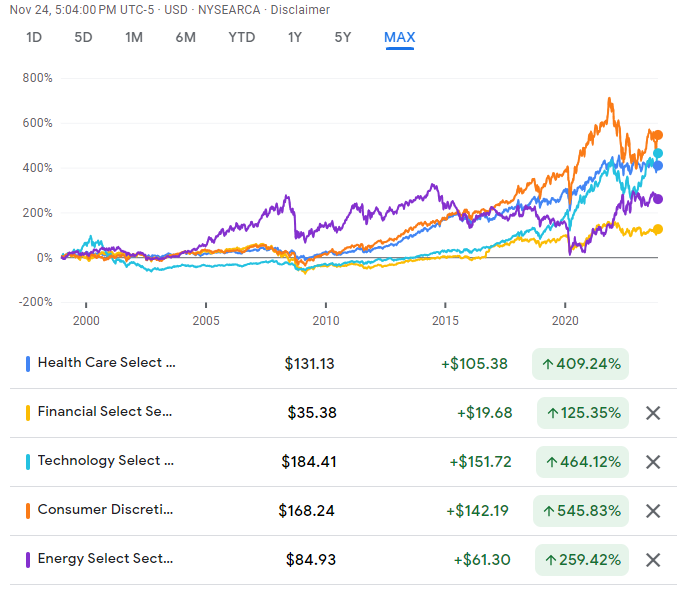

In [ ]:
# List of indices/ETFs from different industries
indices = ['XLV', 'XLK', 'XLY', 'XLE', 'XLF']
industry_mapping = {
    'XLV': 'Healthcare',
    'XLK': 'Technology',
    'XLY': 'Consumer',
    'XLE': 'Energy',
    'XLF': 'Finance'
}

# Creating an empty DataFrame to hold the average price data for all industries
all_industries_avg_prices = pd.DataFrame()

# Loop through each index to fetch monthly stock data
for index in indices:
    stock_data = yf.Ticker(index)
    hist_data = stock_data.history(period="30y", interval="1mo")

    # Calculate the average of the 'Open', 'High', 'Low', and 'Close' prices
    hist_data['Average'] = hist_data[['Open', 'High', 'Low', 'Close']].mean(axis=1)
    hist_data = hist_data[['Average']]  # Keep only the 'Average' column
    hist_data['Industry'] = industry_mapping[index]  # Add Industry information

    # Append this data to the all_industries_avg_prices DataFrame
    all_industries_avg_prices = pd.concat([all_industries_avg_prices, hist_data])

# Filter the data since January 31, 2000
filtered_avg_prices = all_industries_avg_prices[all_industries_avg_prices.index >= '2000-01-01']
# Convert the index to 'yyyy-MM' format
filtered_avg_prices.index = filtered_avg_prices.index.tz_convert(None)
filtered_avg_prices.index = filtered_avg_prices.index.strftime('%Y-%m')

# Display the first few rows of the filtered average prices
filtered_avg_prices.head()


,Average,Industry
Date,,
2000-01,21.666930,Healthcare
2000-02,20.606246,Healthcare
2000-03,20.666708,Healthcare
2000-04,21.015685,Healthcare
2000-05,20.828829,Healthcare


# Merging all the data together

In [ ]:
import pandas as pd

# If 'Date' is a column in filtered_avg_prices, set it as the index
if 'Date' in filtered_avg_prices.columns:
    filtered_avg_prices.set_index('Date', inplace=True)

# Convert the index of filtered_avg_prices to datetime if it's not already
filtered_avg_prices.index = pd.to_datetime(filtered_avg_prices.index)

# Ensure the 'Date' column in economic_data is of datetime type
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

# Set 'Date' as index in economic_data for merging
merged_data.set_index('Date', inplace=True)

# Merge the data
df = filtered_avg_prices.merge(merged_data, left_index=True, right_index=True, how='left')

# Reset index if needed
df.reset_index(inplace=True)

# Check the merged data
df.head()


,Date,Average,Industry,Monthly Federal Funds Rate,Monthly CPI,Monthly Unemployment Rate,Monthly 10-Year Treasury Yield,Monthly Credit Card Debt,Income,Money_supply_monthly,Monthly Real GDP Index,Outlook
0,2000-01-01,21.666930,Healthcare,5.45,2.350195,4.0,6.12,2164000.0,9799.9,1122.1,13812.329786,Negative
1,2000-01-01,39.657373,Technology,5.45,2.350195,4.0,6.12,2164000.0,9799.9,1122.1,13812.329786,Negative
2,2000-01-01,21.932750,Consumer,5.45,2.350195,4.0,6.12,2164000.0,9799.9,1122.1,13812.329786,Negative
3,2000-01-01,14.948468,Energy,5.45,2.350195,4.0,6.12,2164000.0,9799.9,1122.1,13812.329786,Negative
4,2000-01-01,11.641879,Finance,5.45,2.350195,4.0,6.12,2164000.0,9799.9,1122.1,13812.329786,Negative


In [ ]:
df[df.isnull().any(axis=1)]

,Date,Average,Industry,Monthly Federal Funds Rate,Monthly CPI,Monthly Unemployment Rate,Monthly 10-Year Treasury Yield,Monthly Credit Card Debt,Income,Money_supply_monthly,Monthly Real GDP Index,Outlook
1425,2023-10-01,126.844999,Healthcare,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1426,2023-10-01,165.087498,Technology,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1427,2023-10-01,156.007504,Consumer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1428,2023-10-01,88.027498,Energy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1429,2023-10-01,32.680000,Finance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1430,2023-11-01,127.712502,Healthcare,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1431,2023-11-01,174.840004,Technology,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1432,2023-11-01,160.597500,Consumer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1433,2023-11-01,85.112501,Energy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1434,2023-11-01,33.897499,Finance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = df.dropna()
df[df.isnull().any(axis=1)]

,Date,Average,Industry,Monthly Federal Funds Rate,Monthly CPI,Monthly Unemployment Rate,Monthly 10-Year Treasury Yield,Monthly Credit Card Debt,Income,Money_supply_monthly,Monthly Real GDP Index,Outlook


## Data Preparation for Analysis


*   Standardize Quantitative Variables: Apply Z-score normalization to all quantitative variables.
*   Encode Qualitative Variable (Outlook): Convert the 'Outlook' variable to numerical form (1 for positive, -1 for negative).

* Creating dummy variables for Industry attribute


In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardizing quantitative variables
scaler = StandardScaler()
quantitative_columns = ['Average', 'Monthly Federal Funds Rate', 'Monthly CPI',
                        'Monthly Unemployment Rate', 'Monthly 10-Year Treasury Yield',
                        'Monthly Credit Card Debt', 'Income', 'Money_supply_monthly',
                        'Monthly Real GDP Index']  # List all quantitative column names
df[quantitative_columns] = scaler.fit_transform(df[quantitative_columns])

# Encoding 'Outlook' qualitative variable
df['Outlook'] = df['Outlook'].map({'Stable': 1, 'Negative': -1})

# Check the first few rows to verify the changes
df.head()

,Date,Average,Industry,Monthly Federal Funds Rate,Monthly CPI,Monthly Unemployment Rate,Monthly 10-Year Treasury Yield,Monthly Credit Card Debt,Income,Money_supply_monthly,Monthly Real GDP Index,Outlook
0,2000-01-01,-0.580504,Healthcare,1.925308,-0.224095,-0.90889,2.315501,-0.446016,-1.623602,-0.57223,-1.652456,-1
1,2000-01-01,-0.096116,Technology,1.925308,-0.224095,-0.90889,2.315501,-0.446016,-1.623602,-0.57223,-1.652456,-1
2,2000-01-01,-0.573347,Consumer,1.925308,-0.224095,-0.90889,2.315501,-0.446016,-1.623602,-0.57223,-1.652456,-1
3,2000-01-01,-0.761397,Energy,1.925308,-0.224095,-0.90889,2.315501,-0.446016,-1.623602,-0.57223,-1.652456,-1
4,2000-01-01,-0.850426,Finance,1.925308,-0.224095,-0.90889,2.315501,-0.446016,-1.623602,-0.57223,-1.652456,-1


In [ ]:
# Check unique values in the 'Outlook' column
unique_outlook_values = df['Outlook'].unique()
print("Unique Outlook Values:", unique_outlook_values)

Unique Outlook Values: [-1  1]


### Create Dummy Variables for 'Industry' in df

In [ ]:
# Creating dummy variables for the 'Industry' category
industry_dummies = pd.get_dummies(df['Industry'], drop_first=True)

# Adding these dummy variables to your DataFrame
df_dummies = pd.concat([df, industry_dummies], axis=1)

# Drop the original 'Industry' column
df_dummies = df_dummies.drop(['Industry'], axis=1)
df_dummies = df_dummies.drop(['Date'], axis=1)

df_dummies.head()


,Average,Monthly Federal Funds Rate,Monthly CPI,Monthly Unemployment Rate,Monthly 10-Year Treasury Yield,Monthly Credit Card Debt,Income,Money_supply_monthly,Monthly Real GDP Index,Outlook,Energy,Finance,Healthcare,Technology
0,-0.580504,1.925308,-0.224095,-0.90889,2.315501,-0.446016,-1.623602,-0.57223,-1.652456,-1,0,0,1,0
1,-0.096116,1.925308,-0.224095,-0.90889,2.315501,-0.446016,-1.623602,-0.57223,-1.652456,-1,0,0,0,1
2,-0.573347,1.925308,-0.224095,-0.90889,2.315501,-0.446016,-1.623602,-0.57223,-1.652456,-1,0,0,0,0
3,-0.761397,1.925308,-0.224095,-0.90889,2.315501,-0.446016,-1.623602,-0.57223,-1.652456,-1,1,0,0,0
4,-0.850426,1.925308,-0.224095,-0.90889,2.315501,-0.446016,-1.623602,-0.57223,-1.652456,-1,0,1,0,0


## Exploratory Data Analysis (EDA)


*   Correlation Analysis: Generate a correlation matrix for the quantitative variables.





In [ ]:
quantitative_columns = ['Average', 'Monthly Federal Funds Rate', 'Monthly CPI',
                        'Monthly Unemployment Rate', 'Monthly 10-Year Treasury Yield',
                        'Monthly Credit Card Debt', 'Income', 'Money_supply_monthly',
                        'Monthly Real GDP Index', 'Outlook']

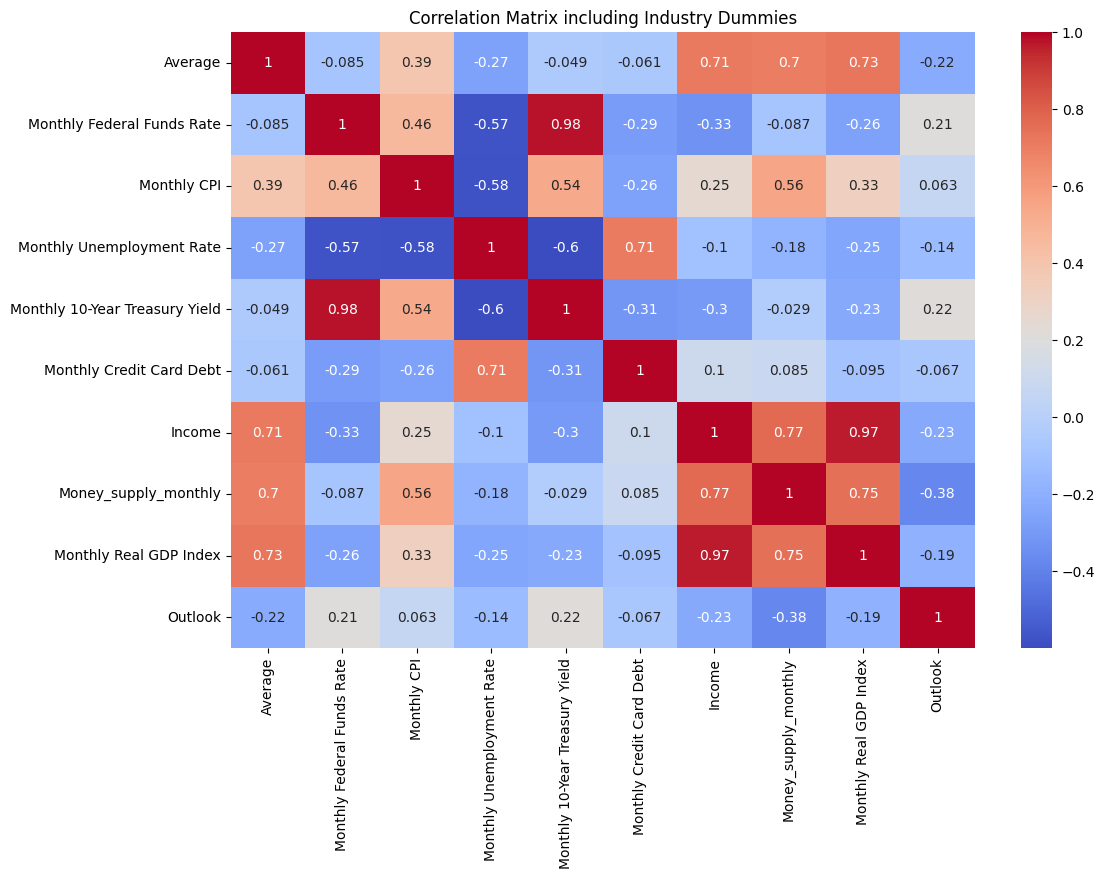

In [ ]:
# Correlation matrix
correlation_matrix = df_dummies[quantitative_columns].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix including Industry Dummies")
plt.show()


# Regression Analysis
* Fit the Model: Use a linear regression model to analyze the data.
* Outlier Detection: Identify and handle outliers in the data.
* Statistical Tests: Perform tests like t-test for coefficients and F-test for overall model significance.

In [ ]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split


X = df_dummies.drop('Average', axis=1)  # Predictor variables
y = df_dummies['Average']                # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Adding a constant to the model (intercept)
X_train_sm = sm.add_constant(X_train)

# Fitting the regression model
model = sm.OLS(y_train, X_train_sm).fit()

# Print out the statistics
model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Average   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     222.3
Date:                Mon, 27 Nov 2023   Prob (F-statistic):          8.91e-282
Time:                        05:12:49   Log-Likelihood:                -756.69
No. Observations:                 997   AIC:                             1541.
Df Residuals:                     983   BIC:                             1610.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.5474      0.039     14.021      0.000       0.471       0.624
Monthly Federal Funds Rate         0.0621      0.088      0.703      0.483      -0.111       0.236
Monthly CPI                       -0.0078      0.030     -0.260      0.795      -0.067       0.051
Monthly Unemployment Rate         -0.1365      0.035     -3.948      0.000      -0.204      -0.069
Monthly 10-Year Treasury Yield    -0.0436      0.094     -0.466      0.641      -0.227       0.140
Monthly Credit Card Debt          -0.0107      0.034     -0.311      0.756      -0.078       0.057
Income                             0.2799      0.107      2.620      0.009       0.070       0.490
Money_supply_monthly               0.3116      0.038      8.227      0.000       0.237       0.386
Monthly Real GDP Index             0.1979      0.104      1.898      0.058      -0.007       0.403
Outlook                           -0.0659      0.025     -2.662      0.008      -0.114      -0.017
Energy                            -0.5698      0.052    -11.025      0.000      -0.671      -0.468
Finance                           -1.2046      0.051    -23.539      0.000      -1.305      -1.104
Healthcare                        -0.3165      0.052     -6.097      0.000      -0.418      -0.215
Technology                        -0.4300      0.052     -8.289      0.000      -0.532      -0.328
==============================================================================
Omnibus:                       36.240   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.266
Skew:                          -0.054   Prob(JB):                     2.06e-21
Kurtosis:                       4.511   Cond. No.                         16.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##  Model Evaluation

In [ ]:
# Adding a constant to the X_test
X_test_sm = sm.add_constant(X_test)

# Making predictions
y_pred = model.predict(X_test_sm)

# Evaluate the model (e.g., using R-squared, RMSE, etc.)
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r_squared}')


Mean Squared Error: 0.2242276507290066
R-squared: 0.7437912189780744


# Analysis and Interpretation


1. Good Model Fit: The R-squared value of 0.746 indicates that about 74.6% of the variability in the average stock prices is explained by the model. This suggests a strong overall fit. F-statistic (222.3): This value is significantly high, suggesting that the overall model is statistically significant.

2. Significant Predictors:  Monthly Unemployment Rate shows a significant negative association, indicating that higher unemployment rates are correlated with lower average stock prices. Income and Money_supply_monthly are positively associated with the average stock prices, suggesting that higher disposable income and larger money supplies are linked with higher stock prices.

3. Less Significant Predictors: Monthly Federal Funds Rate, Monthly CPI, Monthly 10-Year Treasury Yield, and Monthly Credit Card Debt do not show significant associations.

4. Industry Effects (Dummy Variables): The model uses Consumer as the baseline industry since it's not listed as a dummy variable. The coefficients for other industries are interpreted relative to this baseline.
Energy: Shows a significant negative association, indicating lower average stock prices compared to the Consumer industry.
Finance: Also indicates significantly lower average stock prices compared to the Consumer industry.
Healthcare and Technology: Both industries show significant negative associations, suggesting lower average stock prices compared to the Consumer industry.

 Healthcare (-0.3165): Best performing among the listed industries.

  Technology (-0.4300): Second best.

  Energy (-0.5698): Third.

  Finance (-1.2046): Fourth (and the worst performing among these industries).


The model effectively captures the impact of various economic metrics and industry-specific trends on average stock prices.
The negative coefficients for all industry dummy variables suggest that each of these industries, on average, underperforms compared to the baseline category in terms of stock prices.
Addressing potential issues in residual normality and considering the nonsignificant variables could further refine the model.



# Calculate VIF for Each Predictor

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming df_dummies is your DataFrame
X = df_dummies.drop(['Average', 'Energy', 'Finance', 'Healthcare', 'Technology'], axis=1)

# Adding a constant
X = sm.add_constant(X)

# Calculating VIF for each variable
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


                          Feature        VIF
0                           const   1.788358
1      Monthly Federal Funds Rate  28.716170
2                     Monthly CPI   3.475481
3       Monthly Unemployment Rate   4.275323
4  Monthly 10-Year Treasury Yield  32.206584
5        Monthly Credit Card Debt   4.045002
6                          Income  41.313855
7            Money_supply_monthly   5.607143
8          Monthly Real GDP Index  38.818643
9                         Outlook   1.507687


Variables with High VIF:

Monthly Federal Funds Rate (VIF = 28.716170)

Monthly 10-Year Treasury Yield (VIF = 32.206584)

Income (VIF = 41.313855)

Monthly Real GDP Index (VIF = 38.818643)

These variables have high VIFs and might be candidates for removal or transformation in the next model iteration.



#Fitting new model after considering significance and VIF

In [ ]:
import statsmodels.api as sm


# Selecting the statistically significant variables
# Note: 'Income' and 'Monthly Real GDP Index' are kept for now despite high VIF because of their significance
significant_vars = [
    'Monthly Unemployment Rate',
    'Income',
    'Money_supply_monthly',
    'Outlook',
    'Energy',
    'Finance',
    'Healthcare',
    'Technology'
]

# Selecting the data for these variables
X_new = df_dummies[significant_vars]
y_new = df_dummies['Average']  # Target variable remains the same

# Adding a constant to the model (intercept)
X_new = sm.add_constant(X_new)

# Fitting the new OLS model
model_new = sm.OLS(y_new, X_new).fit()

# Printing the summary of the new model
model_new_summary = model_new.summary()
print(model_new_summary)


                            OLS Regression Results                            
Dep. Variable:                Average   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     515.3
Date:                Mon, 27 Nov 2023   Prob (F-statistic):               0.00
Time:                        05:12:49   Log-Likelihood:                -1050.2
No. Observations:                1425   AIC:                             2118.
Df Residuals:                    1416   BIC:                             2166.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

Model Fit and Quality:
R-squared (0.744): Almost 74.4% of the variance in the average stock prices is accounted for by the model, which is robust.

Adjusted R-squared (0.743): After adjusting for the number of predictors, the model still shows a high level of explanatory power.

F-statistic (515.3): The model is statistically significant with a very low p-value, indicating that the overall model has a strong predictive ability.
Coefficients and Their Interpretation

Monthly Unemployment Rate (-0.1644): A significant predictor, indicating that as the unemployment rate increases, average stock prices tend to decrease.

Income (0.4406): A significant positive predictor, suggesting that higher income levels are associated with higher average stock prices.

Money_supply_monthly (0.3277): Also significant and positive, implying an increase in money supply correlates with higher stock prices.

Outlook (-0.0260): Although negative, it's not statistically significant (p = 0.162), suggesting that the outlook does not have a strong predictive power in this model.

Industry Dummies: All industry categories are significant with negative coefficients compared to the baseline (consumer discretionaries):
Energy (-0.5512)

Finance (-1.1732)

Healthcare (-0.2967)

Technology (-0.4285)

These coefficients suggest that, on average, these industries have lower stock prices compared to the baseline category, with Finance showing the most significant negative difference.
Overall, the model shows a strong relationship between the selected predictors and the average stock prices across different industries. Further refinement could involve addressing the normality of residuals and potentially exploring other variables that could add explanatory power or replace less significant predictors.

In [ ]:
import statsmodels.api as sm


# Selecting the statistically significant variables
# Note: 'Income' and 'Monthly Real GDP Index' are kept for now despite high VIF because of their significance
significant_vars = [
    'Monthly Unemployment Rate',
    'Income',
    'Money_supply_monthly',
    'Energy',
    'Finance',
    'Healthcare',
    'Technology'
]

# Selecting the data for these variables
X_new = df_dummies[significant_vars]
y_new = df_dummies['Average']  # Target variable remains the same

# Adding a constant to the model (intercept)
X_new = sm.add_constant(X_new)

# Fitting the new OLS model
model3 = sm.OLS(y_new, X_new).fit()

# Printing the summary of the new model
model3_summary = model3.summary()
print(model3_summary)


                            OLS Regression Results                            
Dep. Variable:                Average   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     588.3
Date:                Mon, 27 Nov 2023   Prob (F-statistic):               0.00
Time:                        05:19:01   Log-Likelihood:                -1051.2
No. Observations:                1425   AIC:                             2118.
Df Residuals:                    1417   BIC:                             2160.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

Model Fit and Quality
R-squared (0.744): The model still explains approximately 74.4% of the variance in the average stock prices.

Adjusted R-squared (0.743): Indicates a high level of explanatory power, even after adjusting for the number of predictors.

F-statistic (588.3): Demonstrates that the model is statistically significant.
Coefficients and Their Interpretation

Monthly Unemployment Rate (-0.1598): Continues to show a significant negative relationship with average stock prices.

Income (0.4368): Remains a significant positive predictor.

Money_supply_monthly (0.3394): Indicates a significant positive relationship with average stock prices, with a slightly increased coefficient compared to the previous model.

Industry Dummies: All coefficients are negative, indicating that compared to the baseline (consumer discretionaries), these industries have lower average stock prices. The rankings of industries from the highest negative impact to the least are:

Finance (-1.1732)
Energy (-0.5512)
Technology (-0.4285)
Healthcare (-0.2967)

Address Residual Normality: Check the distribution of residuals to ensure that they meet the assumptions of the model.

Further Refinement: Exploring interaction effects or non-linear relationships if domain knowledge suggests they might be present.

This model appears robust and is likely to provide valuable insights into the factors affecting average stock prices across different industries.

#Residual Analysis Of The Model

In [ ]:
pip install --upgrade statsmodels


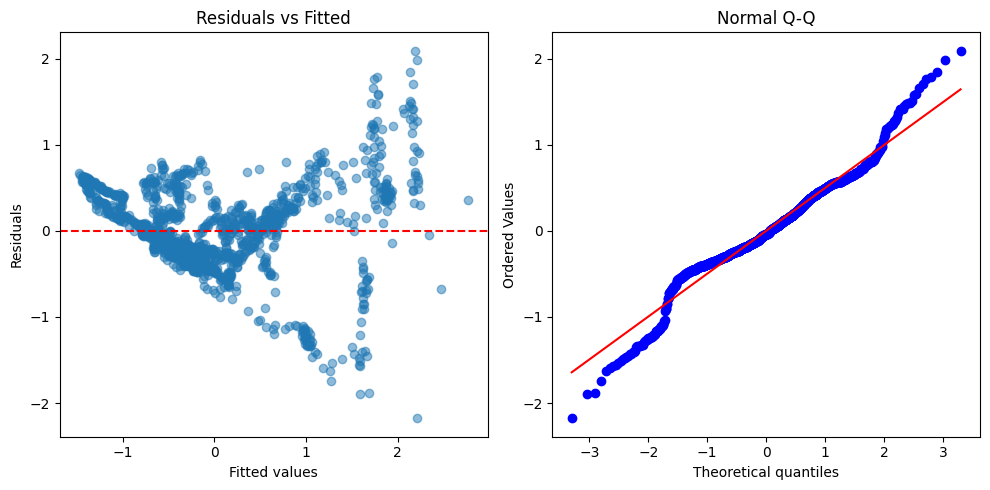

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan

# Assuming 'model3' is the latest fitted OLS model

# Extracting the residuals
residuals = model3.resid

# Plotting the residuals
plt.figure(figsize=(10, 5))

# Residual scatter plot
plt.subplot(1, 2, 1)
plt.scatter(model3.predict(), residuals, alpha=0.5)
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--')


# Q-Q plot using scipy
plt.subplot(1, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Normal Q-Q')

plt.tight_layout()
plt.show()

Residuals vs Fitted Plot:
The "megaphone" shape pattern, where the spread of residuals increases with the fitted values, suggests that there is heteroscedasticity in the residuals. The evident pattern here indicates that the assumption of homoscedasticity may be violated.

Normal Q-Q Plot:
The points follow the red line closely in the center but deviate at the ends. This is an indication that the residuals have heavier tails than the normal distribution, which suggests some departure from normality, particularly for extreme values (indicative of outliers or potential influential observations).


<ipython-input-28-5163c2f9e15b>:14: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(np.arange(len(cooks)), cooks, markerfmt=",", use_line_collection=True)


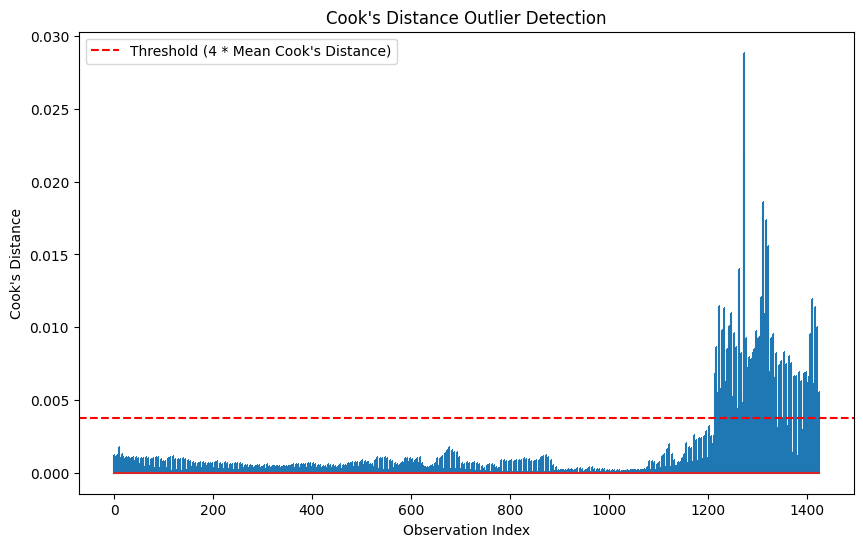

Potential outliers based on Cook's distance:
[1215 1216 1217 1218 1223 1224 1228 1229 1233 1234 1237 1238 1239 1242
 1243 1244 1248 1249 1253 1254 1257 1258 1259 1263 1264 1267 1268 1269
 1273 1274 1277 1278 1279 1282 1283 1284 1286 1287 1288 1289 1291 1292
 1293 1294 1296 1297 1298 1299 1301 1302 1303 1304 1306 1307 1308 1309
 1311 1312 1313 1314 1316 1317 1318 1319 1321 1322 1323 1324 1326 1327
 1328 1329 1331 1332 1333 1334 1336 1337 1339 1344 1349 1353 1354 1357
 1359 1364 1369 1374 1379 1384 1389 1394 1396 1399 1401 1404 1406 1409
 1411 1412 1414 1416 1417 1419 1421 1422 1424]


In [ ]:
import numpy as np


# Calculating Cook's distance for each observation
influence = model3.get_influence()
cooks = influence.cooks_distance[0]

# Identifying outliers as points where Cook's distance is significantly larger than the mean
mean_cooks = np.mean(cooks)
significant_cooks = np.where(cooks > (4 * mean_cooks))[0]

# Plotting Cook's distance
plt.figure(figsize=(10, 6))
plt.stem(np.arange(len(cooks)), cooks, markerfmt=",", use_line_collection=True)
plt.title('Cook\'s Distance Outlier Detection')
plt.xlabel('Observation Index')
plt.ylabel('Cook\'s Distance')
plt.axhline(4 * mean_cooks, color='r', linestyle='--', label="Threshold (4 * Mean Cook's Distance)")
plt.legend()
plt.show()

# Print the indices of the potential outliers
print("Potential outliers based on Cook's distance:")
print(significant_cooks)


Since in the context of time series data like stock prices and economic indicators, which can naturally exhibit trends and non-stationarity over time.

Nature of Outliers: In financial time series, what may appear as an "outlier" could actually be a genuine representation of market conditions, such as a market crash, correction, or a boom. Removing these could distort the true nature of the data.

Standardization: After standardization, extreme values are less of a problem for the regression coefficients' estimation, as they're on the same scale as the rest of the data. However, large standardized values can still be influential if they have a high leverage.

Economic Indicators: Economic indicators like income and money supply do tend to increase over time due to inflation and growth. Removing these "outliers" might remove important information about economic trends and cycles.

Recent Data: If most of the outliers are from recent years, this could be indicative of a structural break or regime change in the market dynamics, which a static model might not capture.

In conclusion, rather than automatically removing outliers, it's important to understand why they exist and what they represent. Removing them without careful consideration could lead to a loss of valuable information or misunderstanding of the underlying phenomena. If outliers are influential and are valid observations (not data errors), they should be included, and the model should be adjusted to handle them appropriately.

### Trying out log regressor transformation

Log Transformation: This is useful when you have exponential growth or when the variance increases with the level of the dependent variable. It's a common choice for financial data, like stock prices, because it can stabilize the variance across the range of data and it interprets percentage changes in the dependent variable.

In [ ]:
import numpy as np
import statsmodels.api as sm

# Create a new DataFrame for the transformed model, assuming df_dummies is your original DataFrame
df_transformed = df_dummies.copy()

# Determine the minimum value in the 'Average' column
min_value = df_dummies['Average'].min()

# If the minimum value is less than or equal to 0, shift all data to be positive
if min_value <= 0:
    shift_constant = np.abs(min_value) + 1  # Ensure all values are positive
    df_transformed['Average_log'] = np.log(df_dummies['Average'] + shift_constant)
else:
    df_transformed['Average_log'] = np.log(df_dummies['Average'])


# Define the predictor variables, excluding 'Outlook'
significant_vars = [
    'Monthly Unemployment Rate',
    'Income',
    'Money_supply_monthly',
    'Energy',
    'Finance',
    'Healthcare',
    'Technology'
]

# Select the transformed dependent variable and predictor variables for the regression model
X_transformed = df_transformed[significant_vars]
y_transformed = df_transformed['Average_log']

# Add a constant to the model (intercept)
X_transformed = sm.add_constant(X_transformed)

# Fit the new OLS model with the log-transformed dependent variable
model_transformed = sm.OLS(y_transformed, X_transformed).fit()

# Print the summary of the new model
model_transformed_summary = model_transformed.summary()
print(model_transformed_summary)


                            OLS Regression Results                            
Dep. Variable:            Average_log   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     798.8
Date:                Mon, 27 Nov 2023   Prob (F-statistic):               0.00
Time:                        05:13:07   Log-Likelihood:                 417.36
No. Observations:                1425   AIC:                            -818.7
Df Residuals:                    1417   BIC:                            -776.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

Model Fit: The R-squared and Adjusted R-squared values are higher post-transformation, indicating an improved fit of the model to the data.


Coefficient Changes:

The coefficients have changed after the transformation, which is expected since the scale of the dependent variable has changed.
The relative impact of 'Income' and 'Money_supply_monthly' appears to have decreased post-transformation, suggesting that the original scale may have exaggerated their influence.

Significance:

The significance levels of the predictors remain largely the same, with all variables remaining significant (p < 0.05).
This consistency suggests that the relationships are robust across transformations.

Conclusion:
The log transformation has enhanced the model's explanatory power, suggesting that the relationship between the predictors and the logarithm of stock prices is stronger and perhaps more linear than with the raw stock prices.

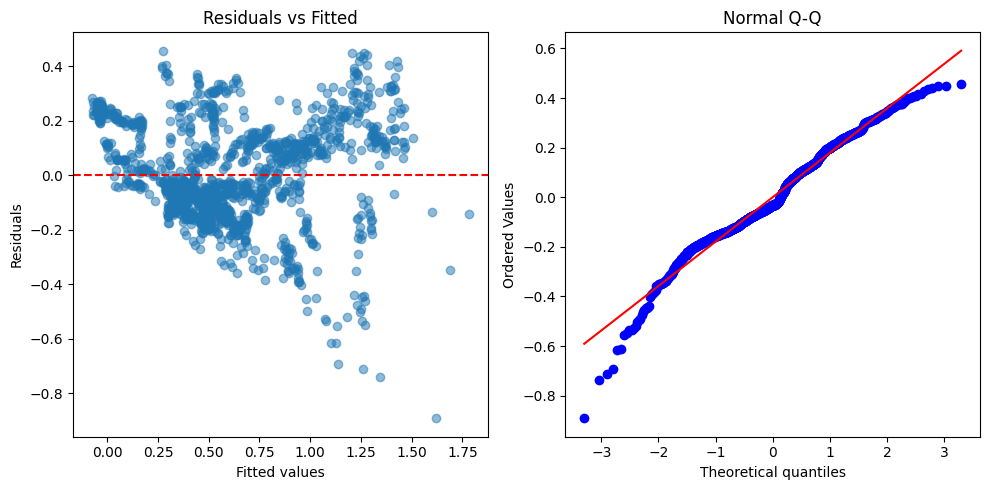

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan

# Assuming 'modeltrandformed' is the latest fitted OLS model

# Extracting the residuals
residuals = model_transformed.resid

# Plotting the residuals
plt.figure(figsize=(10, 5))

# Residual scatter plot
plt.subplot(1, 2, 1)
plt.scatter(model_transformed.predict(), residuals, alpha=0.5)
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--')


# Q-Q plot using scipy
plt.subplot(1, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Normal Q-Q')

plt.tight_layout()
plt.show()

Influence of outliers or leverage points that might still be affecting the model, even after the transformation.
Remaining non-linearity that could potentially be addressed by adding polynomial terms or interaction terms to the model.

The Normal Q-Q plot showing a closer alignment of the data points with the theoretical line suggests that the residuals are more normally distributed in the transformed model.


# Part2: Trying Out Industry wise study

# Filtering out data into it's own sector

In [ ]:
# Creating separate DataFrames for each industry
healthcare_data = df[df['Industry'] == 'Healthcare']
technology_data = df[df['Industry'] == 'Technology']
consumer_data = df[df['Industry'] == 'Consumer']
energy_data = df[df['Industry'] == 'Energy']
finance_data = df[df['Industry'] == 'Finance']

In [ ]:

healthcare_data.head()

,Date,Average,Industry,Monthly Federal Funds Rate,Monthly CPI,Monthly Unemployment Rate,Monthly 10-Year Treasury Yield,Monthly Credit Card Debt,Income,Money_supply_monthly,Monthly Real GDP Index,Outlook
0,2000-01-01,-0.580504,Healthcare,1.925308,-0.224095,-0.908890,2.315501,-0.446016,-1.623602,-0.572230,-1.652456,-1
5,2000-02-01,-0.609063,Healthcare,2.070927,-0.181494,-0.858009,2.370079,-0.449101,-1.605421,-0.574468,-1.627594,-1
10,2000-03-01,-0.607435,Healthcare,2.133335,-0.082936,-0.908890,2.370079,-0.488325,-1.592934,-0.574651,-1.594117,-1
15,2000-04-01,-0.598039,Healthcare,2.221746,-0.153380,-1.010651,2.331875,-0.506395,-1.569155,-0.573307,-1.517602,-1
20,2000-05-01,-0.603070,Healthcare,2.351763,-0.012079,-0.908890,2.430115,-0.524023,-1.549635,-0.575082,-1.525936,-1


In [ ]:
technology_data.head()

,Date,Average,Industry,Monthly Federal Funds Rate,Monthly CPI,Monthly Unemployment Rate,Monthly 10-Year Treasury Yield,Monthly Credit Card Debt,Income,Money_supply_monthly,Monthly Real GDP Index,Outlook
1,2000-01-01,-0.096116,Technology,1.925308,-0.224095,-0.908890,2.315501,-0.446016,-1.623602,-0.572230,-1.652456,-1
6,2000-02-01,-0.079646,Technology,2.070927,-0.181494,-0.858009,2.370079,-0.449101,-1.605421,-0.574468,-1.627594,-1
11,2000-03-01,0.047420,Technology,2.133335,-0.082936,-0.908890,2.370079,-0.488325,-1.592934,-0.574651,-1.594117,-1
16,2000-04-01,-0.029281,Technology,2.221746,-0.153380,-1.010651,2.331875,-0.506395,-1.569155,-0.573307,-1.517602,-1
21,2000-05-01,-0.114734,Technology,2.351763,-0.012079,-0.908890,2.430115,-0.524023,-1.549635,-0.575082,-1.525936,-1


In [ ]:
consumer_data.head()

,Date,Average,Industry,Monthly Federal Funds Rate,Monthly CPI,Monthly Unemployment Rate,Monthly 10-Year Treasury Yield,Monthly Credit Card Debt,Income,Money_supply_monthly,Monthly Real GDP Index,Outlook
2,2000-01-01,-0.573347,Consumer,1.925308,-0.224095,-0.908890,2.315501,-0.446016,-1.623602,-0.572230,-1.652456,-1
7,2000-02-01,-0.627798,Consumer,2.070927,-0.181494,-0.858009,2.370079,-0.449101,-1.605421,-0.574468,-1.627594,-1
12,2000-03-01,-0.609913,Consumer,2.133335,-0.082936,-0.908890,2.370079,-0.488325,-1.592934,-0.574651,-1.594117,-1
17,2000-04-01,-0.564310,Consumer,2.221746,-0.153380,-1.010651,2.331875,-0.506395,-1.569155,-0.573307,-1.517602,-1
22,2000-05-01,-0.595212,Consumer,2.351763,-0.012079,-0.908890,2.430115,-0.524023,-1.549635,-0.575082,-1.525936,-1


In [ ]:
energy_data.head()

,Date,Average,Industry,Monthly Federal Funds Rate,Monthly CPI,Monthly Unemployment Rate,Monthly 10-Year Treasury Yield,Monthly Credit Card Debt,Income,Money_supply_monthly,Monthly Real GDP Index,Outlook
3,2000-01-01,-0.761397,Energy,1.925308,-0.224095,-0.908890,2.315501,-0.446016,-1.623602,-0.572230,-1.652456,-1
8,2000-02-01,-0.777009,Energy,2.070927,-0.181494,-0.858009,2.370079,-0.449101,-1.605421,-0.574468,-1.627594,-1
13,2000-03-01,-0.755850,Energy,2.133335,-0.082936,-0.908890,2.370079,-0.488325,-1.592934,-0.574651,-1.594117,-1
18,2000-04-01,-0.737728,Energy,2.221746,-0.153380,-1.010651,2.331875,-0.506395,-1.569155,-0.573307,-1.517602,-1
23,2000-05-01,-0.713055,Energy,2.351763,-0.012079,-0.908890,2.430115,-0.524023,-1.549635,-0.575082,-1.525936,-1


In [ ]:
finance_data.head()

,Date,Average,Industry,Monthly Federal Funds Rate,Monthly CPI,Monthly Unemployment Rate,Monthly 10-Year Treasury Yield,Monthly Credit Card Debt,Income,Money_supply_monthly,Monthly Real GDP Index,Outlook
4,2000-01-01,-0.850426,Finance,1.925308,-0.224095,-0.908890,2.315501,-0.446016,-1.623602,-0.572230,-1.652456,-1
9,2000-02-01,-0.869629,Finance,2.070927,-0.181494,-0.858009,2.370079,-0.449101,-1.605421,-0.574468,-1.627594,-1
14,2000-03-01,-0.859869,Finance,2.133335,-0.082936,-0.908890,2.370079,-0.488325,-1.592934,-0.574651,-1.594117,-1
19,2000-04-01,-0.832665,Finance,2.221746,-0.153380,-1.010651,2.331875,-0.506395,-1.569155,-0.573307,-1.517602,-1
24,2000-05-01,-0.835859,Finance,2.351763,-0.012079,-0.908890,2.430115,-0.524023,-1.549635,-0.575082,-1.525936,-1


Correlation Matrix

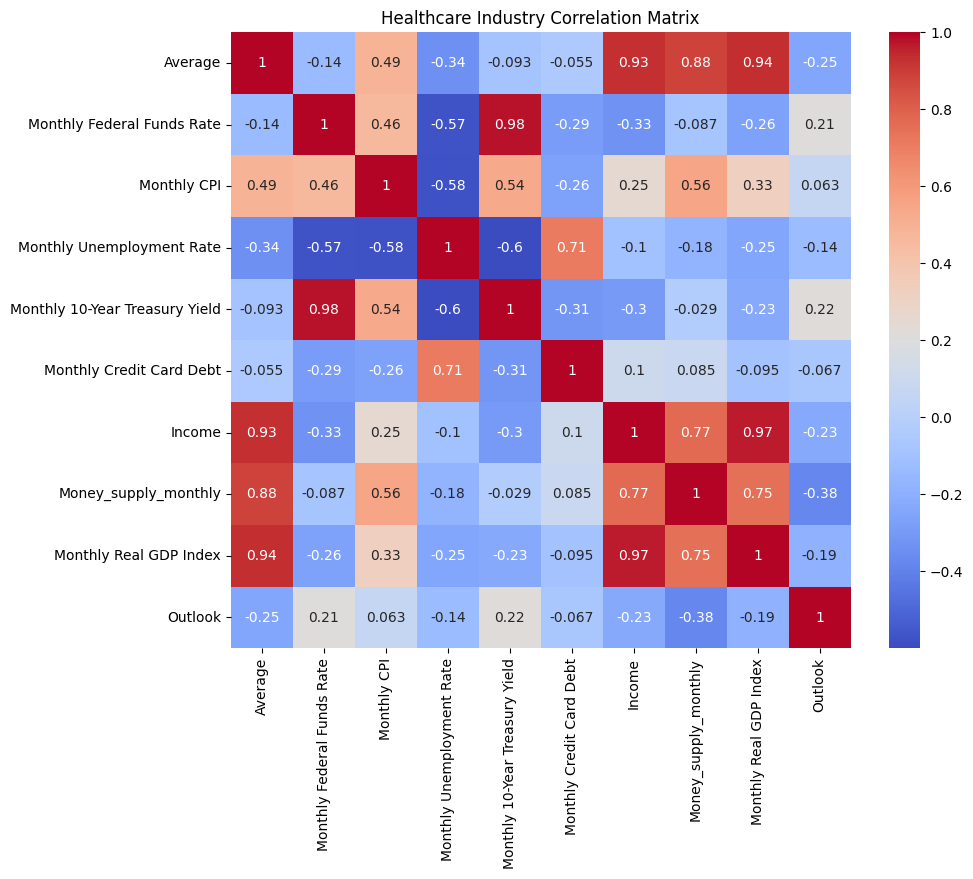

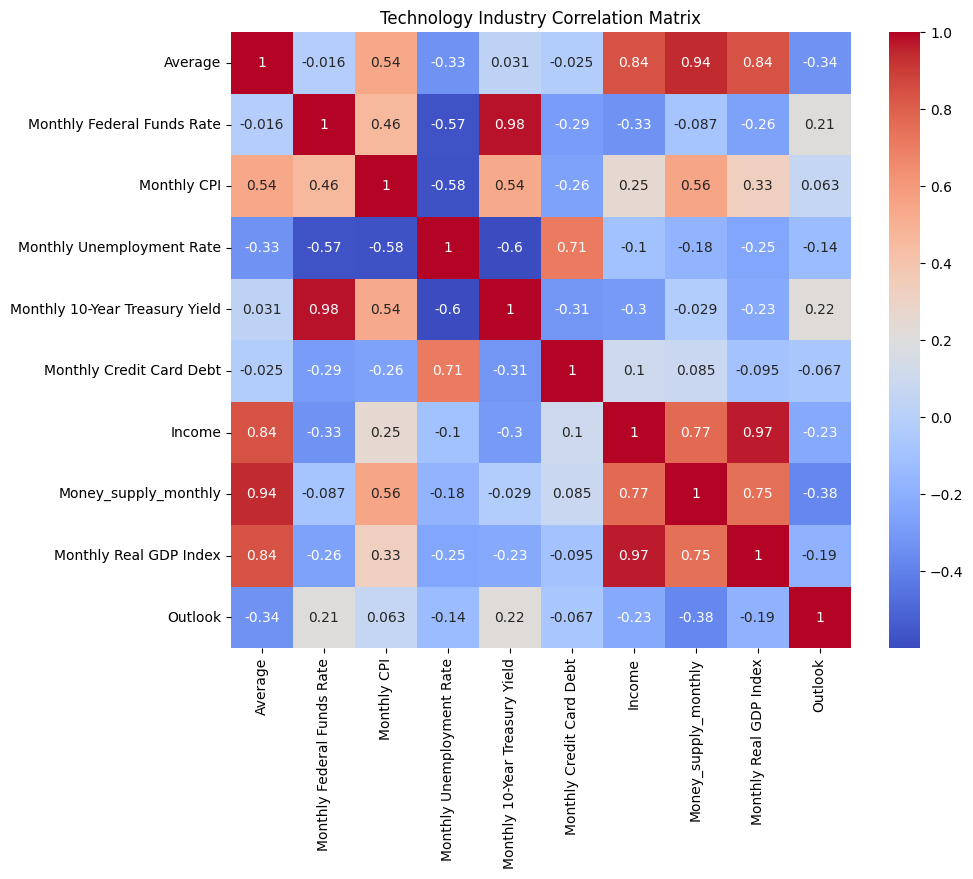

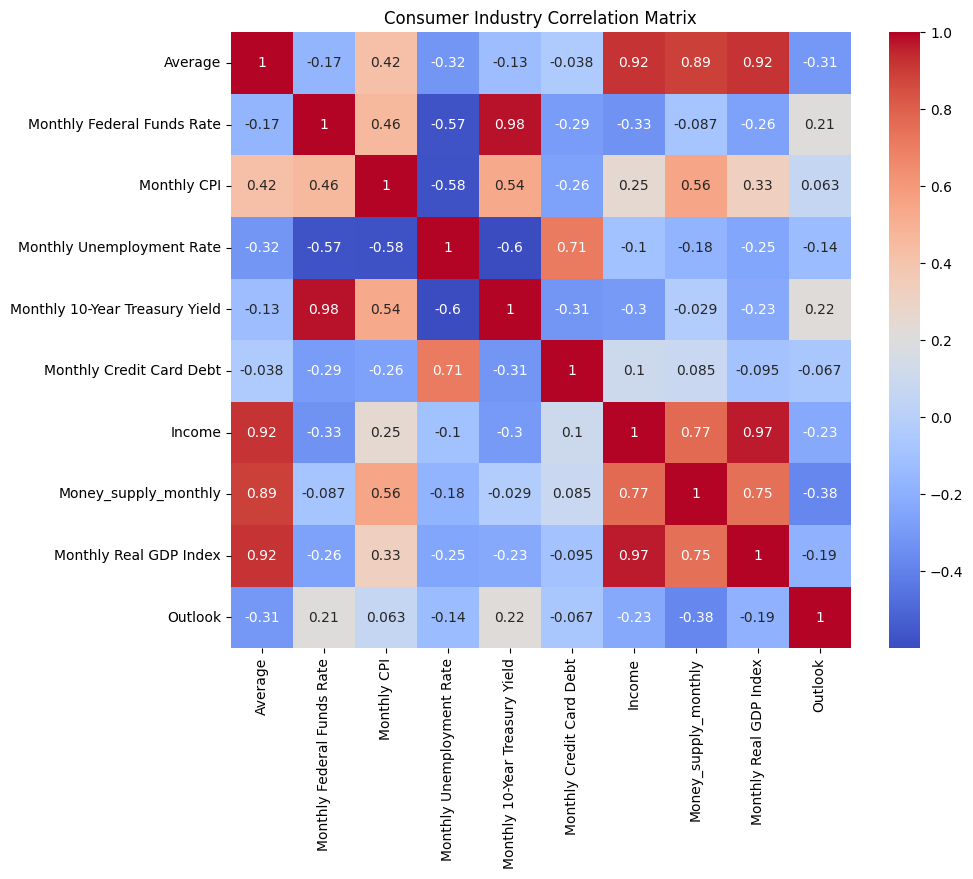

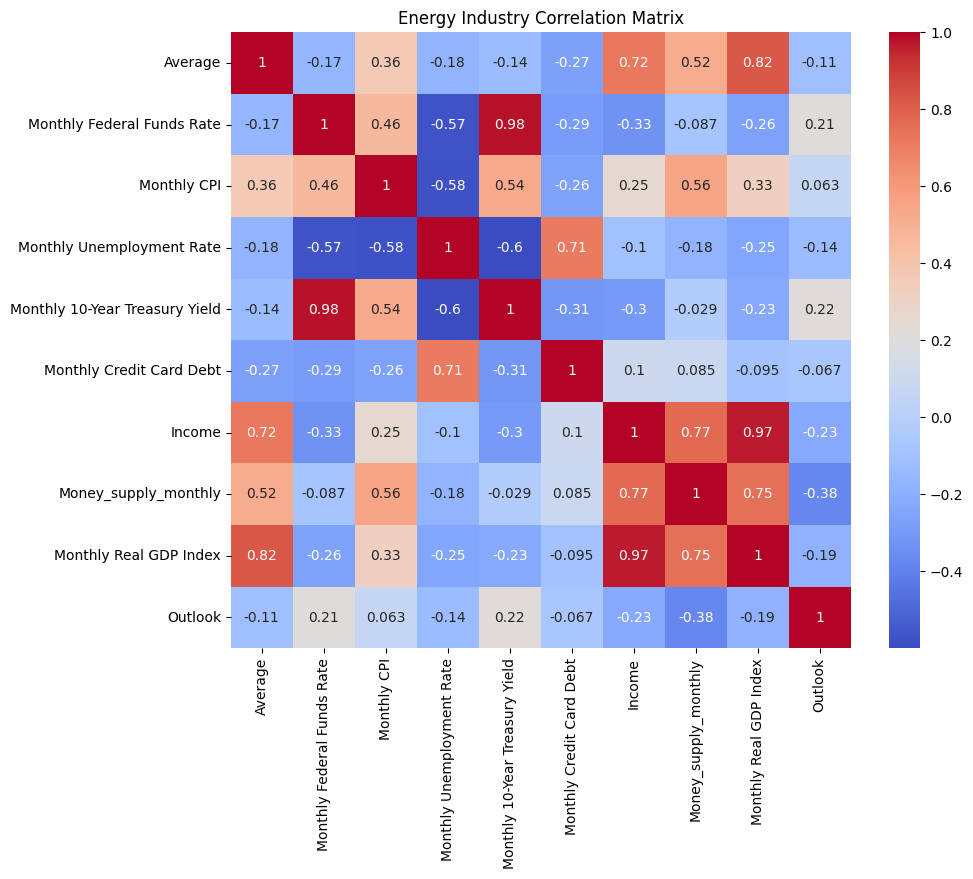

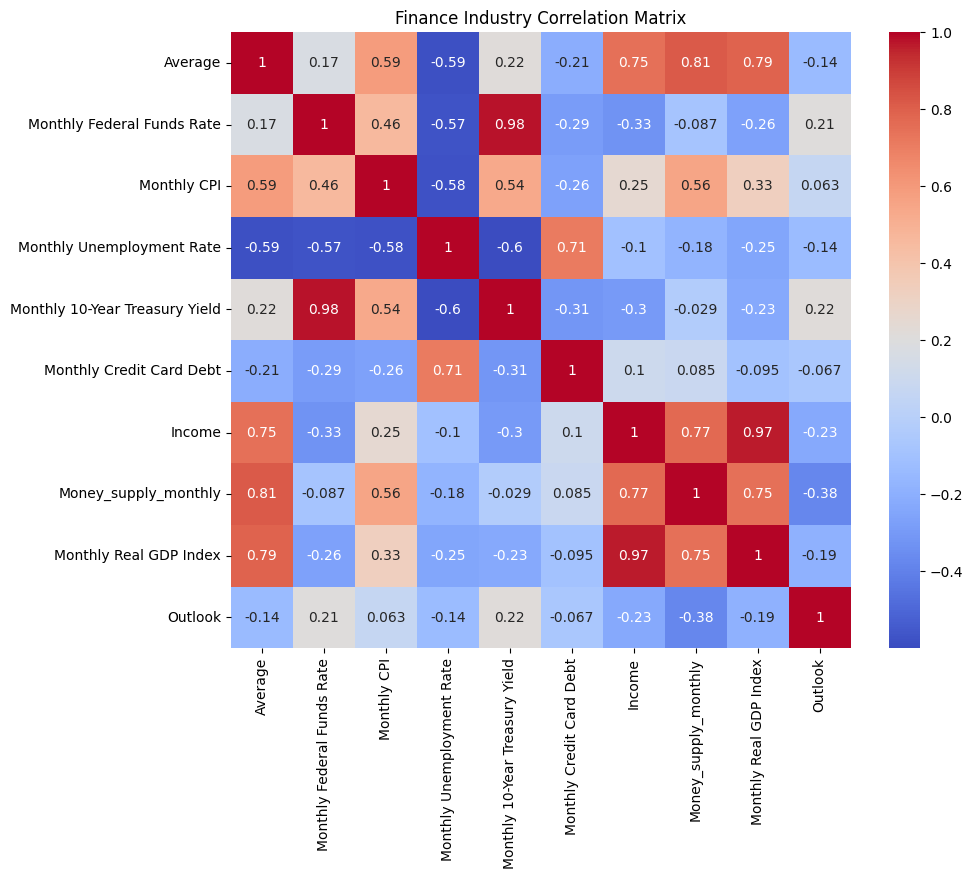

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

quantitative_columns = ['Average', 'Monthly Federal Funds Rate', 'Monthly CPI',
                        'Monthly Unemployment Rate', 'Monthly 10-Year Treasury Yield',
                        'Monthly Credit Card Debt', 'Income', 'Money_supply_monthly',
                        'Monthly Real GDP Index', 'Outlook']

# Creating a dictionary of DataFrames for each industry
industry_data = {
    'Healthcare': df[df['Industry'] == 'Healthcare'],
    'Technology': df[df['Industry'] == 'Technology'],
    'Consumer': df[df['Industry'] == 'Consumer'],
    'Energy': df[df['Industry'] == 'Energy'],
    'Finance': df[df['Industry'] == 'Finance']
}

# Looping over the dictionary to create and display a correlation matrix for each industry
for industry_name, data in industry_data.items():
    plt.figure(figsize=(10, 8))
    correlation_matrix = data[quantitative_columns].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title(f"{industry_name} Industry Correlation Matrix")
    plt.show()


In [ ]:
import statsmodels.api as sm

# Looping over each industry dataset to fit a regression model
for industry_name, data in industry_data.items():
    # Separating the regressor (Average) and predictors
    X = data[quantitative_columns[1:]]  # All columns except 'Average'
    y = data['Average']  # 'Average' is the regressor

    # Adding a constant to the predictors
    X = sm.add_constant(X)

    # Fitting the OLS regression model
    model = sm.OLS(y, X).fit()

    # Printing the model summary
    print(f"Regression Results for {industry_name} Industry")
    print(model.summary())
    print("\n\n")


Regression Results for Healthcare Industry
                            OLS Regression Results                            
Dep. Variable:                Average   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     1239.
Date:                Mon, 27 Nov 2023   Prob (F-statistic):          7.12e-217
Time:                        05:13:17   Log-Likelihood:                 135.54
No. Observations:                 285   AIC:                            -251.1
Df Residuals:                     275   BIC:                            -214.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

In [ ]:
import statsmodels.api as sm

def stepwise_backward_selection(data, response_variable, list_of_predictors):
    while len(list_of_predictors) > 0:
        # Initialize variables
        remaining_predictors = list_of_predictors[:]
        model = sm.OLS(data[response_variable], sm.add_constant(data[remaining_predictors])).fit()
        # Find the predictor with the highest p-value
        pvalues = model.pvalues.iloc[1:]  # exclude the intercept
        max_p_value = pvalues.max()
        if max_p_value > 0.05:
            # Remove the predictor with the highest p-value
            excluded_predictor = pvalues.idxmax()
            remaining_predictors.remove(excluded_predictor)
            list_of_predictors = remaining_predictors[:]
        else:
            # Stop the process if all p-values are below 0.05
            break
    # Fit the final model
    model = sm.OLS(data[response_variable], sm.add_constant(data[remaining_predictors])).fit()
    return model

# Define the predictors and the response variable
response_var = 'Average'
predictors = quantitative_columns.copy()
predictors.remove(response_var)  # Remove the response variable from the predictors list

# Apply stepwise backward selection to each industry data
final_models = {}
for industry in industry_data:
    print(f"Processing {industry} industry...")
    data = industry_data[industry]
    final_models[industry] = stepwise_backward_selection(data, response_var, predictors)

# Display the final models for each industry
for industry, model in final_models.items():
    print(f"Final Model for {industry} Industry:")
    print(model.summary())
    print("\n")


Processing Healthcare industry...
Processing Technology industry...
Processing Consumer industry...
Processing Energy industry...
Processing Finance industry...
Final Model for Healthcare Industry:
                            OLS Regression Results                            
Dep. Variable:                Average   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     1855.
Date:                Mon, 27 Nov 2023   Prob (F-statistic):          5.47e-221
Time:                        05:13:17   Log-Likelihood:                 133.78
No. Observations:                 285   AIC:                            -253.6
Df Residuals:                     278   BIC:                            -228.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
            

Healthcare Industry:

  R-squared: 0.976

  High model fit with significant predictors, including 'Monthly Federal Funds Rate', 'Monthly Unemployment Rate', 'Monthly Credit Card Debt', 'Income', 'Money_supply_monthly', and 'Monthly Real GDP Index'. The model does not retain 'Outlook' and 'Monthly CPI' as significant predictors.

Technology Industry:

  R-squared: 0.955
  Also, a high model fit with fewer predictors than the healthcare industry. It retains 'Outlook' as a significant variable alongside 'Monthly Federal Funds Rate', 'Monthly Unemployment Rate', 'Income', and 'Money_supply_monthly'.

Consumer Industry:

  R-squared: 0.975

  Similar to healthcare, the consumer industry model has high explanatory power. It keeps 'Outlook' as a predictor and drops 'Monthly 10-Year Treasury Yield' and 'Monthly Federal Funds Rate'.

Energy Industry:

  R-squared: 0.871

  Shows strong model fit but not as high as the previous industries. It includes 'Outlook' and 'Monthly CPI' as significant predictors along with other variables like 'Monthly Unemployment Rate' and 'Monthly Real GDP Index'.

Finance Industry:

  R-squared: 0.928

  This model demonstrates a very good fit and includes 'Outlook' as a significant predictor. Unlike other industries, the 'Monthly 10-Year Treasury Yield' is significant, indicating its unique influence on the finance industry's stock prices.

Summary:
  Across industries, the models demonstrate that economic indicators such as 'Income', 'Money_supply_monthly', and 'Monthly Unemployment Rate' consistently play significant roles in explaining the variation in average monthly stock prices. 'Outlook' varies in significance across industries, indicating its impact might be context-specific.

  The presence of 'Income' and 'Money_supply_monthly' as significant predictors across all industries suggests that general economic health and liquidity are important determinants of stock price movements.

  However, each industry does display unique characteristics:

  Healthcare: Shows sensitivity to broader economic indicators like 'Real GDP' and 'Federal Funds Rate'.

  Technology: Has a high R-squared, indicating strong model fit, with 'Outlook' being notably significant.

  Consumer: Reflects a sensitivity to unemployment rates and general economic conditions.

  Energy: Displays a unique relationship with CPI, indicating a possible connection to energy prices and inflation.

  Finance: Is uniquely influenced by interest rates, as shown by the significance of the '10-Year Treasury Yield'.

The high R-squared values across all models suggest that these variables are good predictors of stock price movements within their respective industries.

These models provide valuable insights into the factors driving stock prices in different sectors of the economy. They highlight the importance of industry-specific analyses and the need to consider a range of economic indicators when evaluating stock performance. Each model should be interpreted within the context of industry-specific dynamics and external economic conditions.

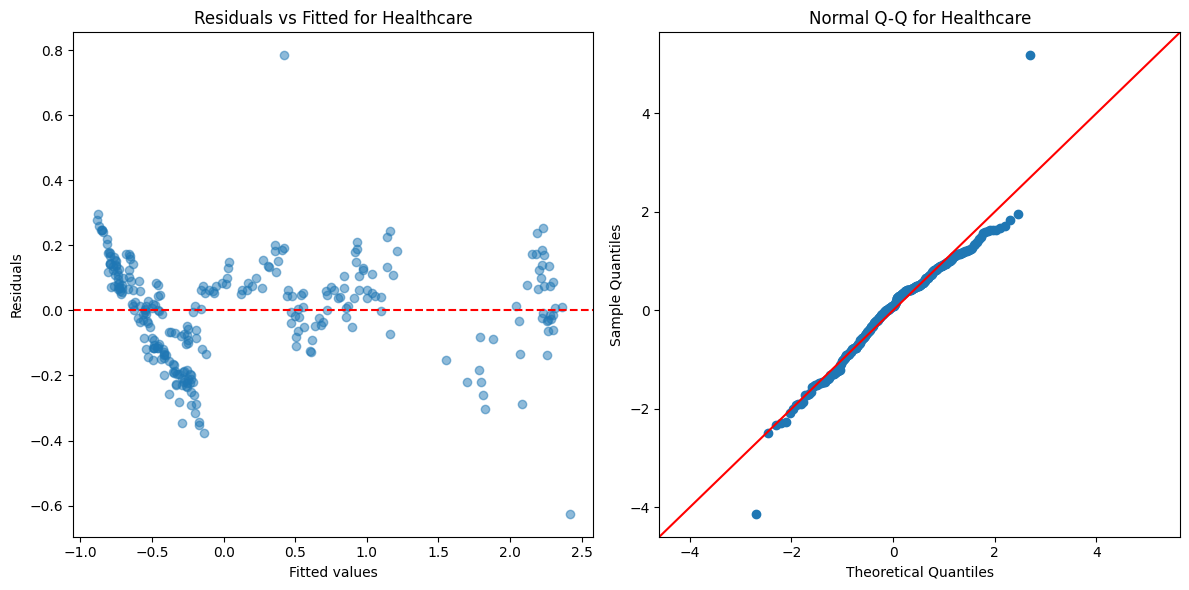

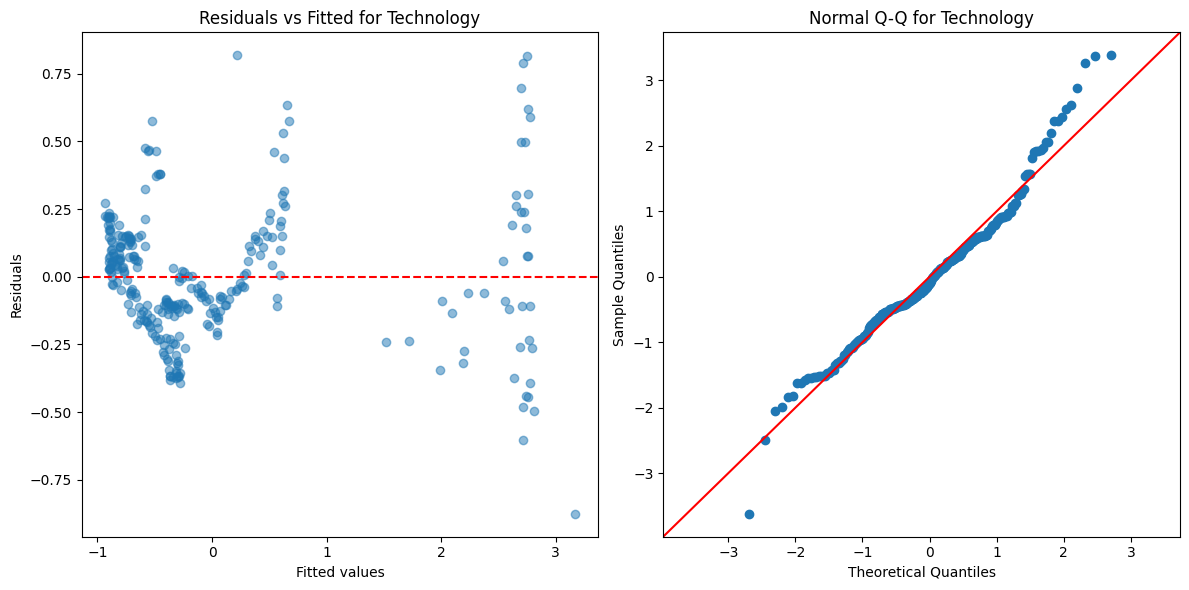

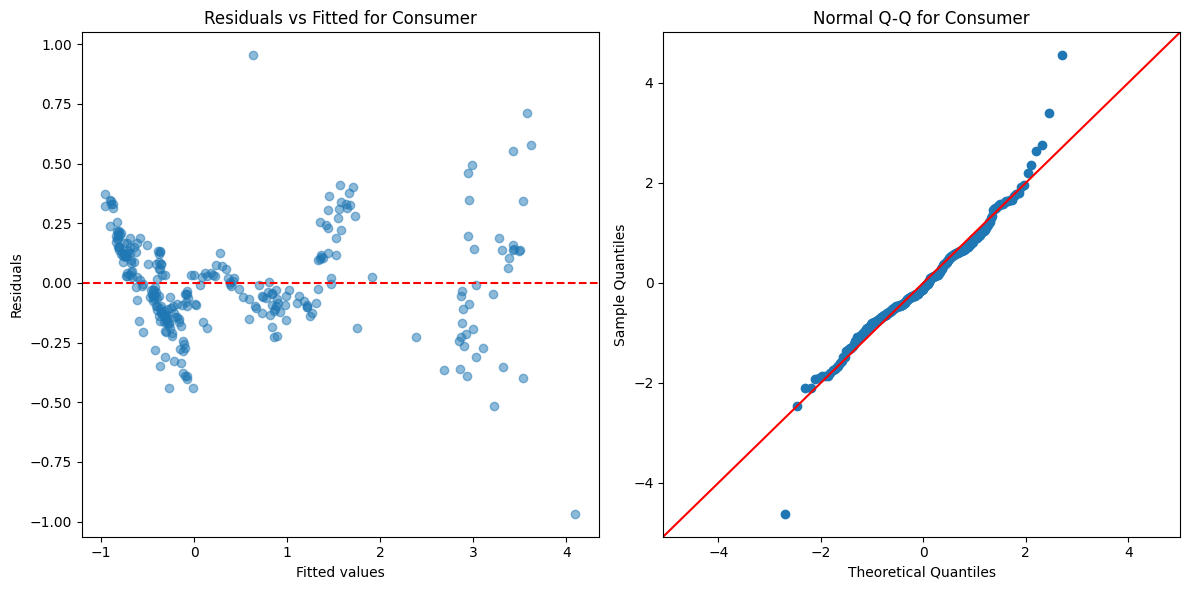

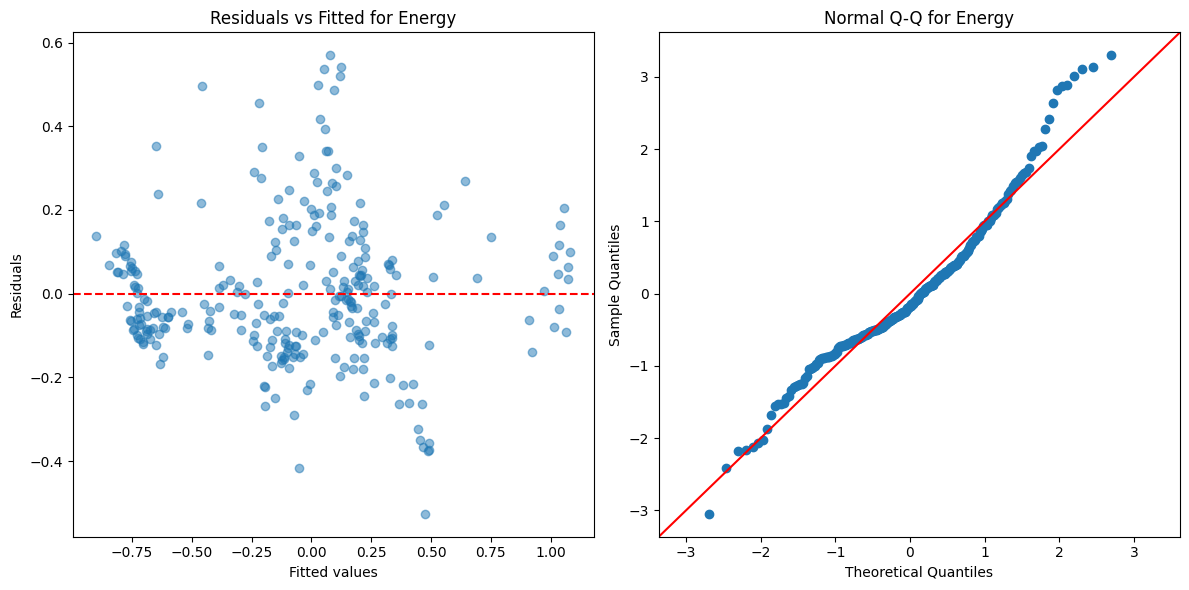

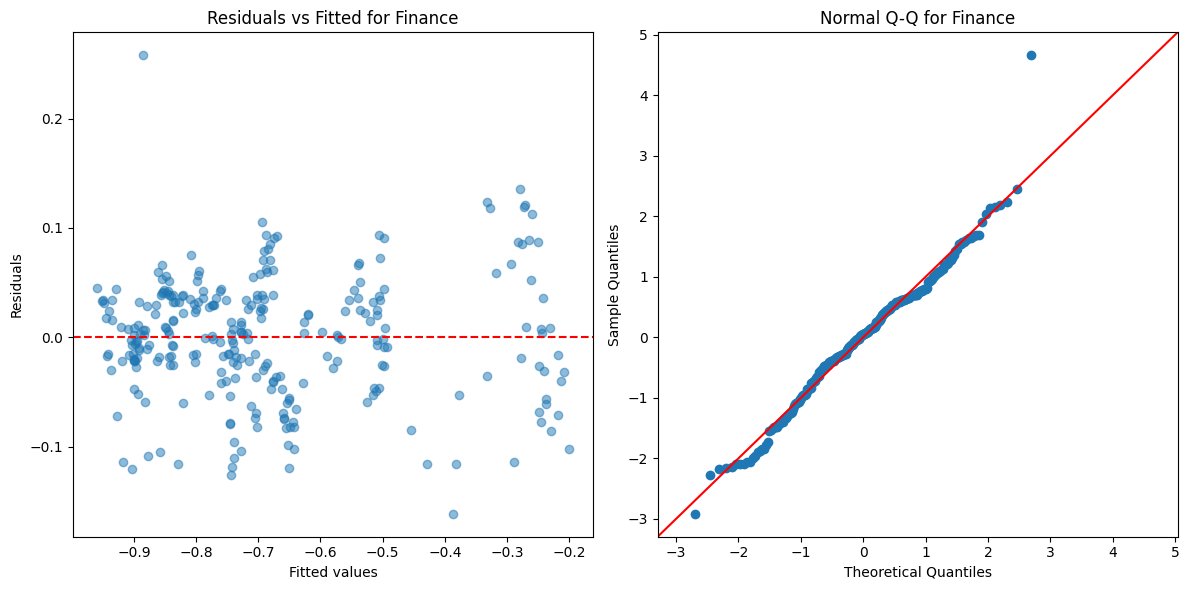

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

# Function to create residual vs fitted and qq plots for a given OLS model
def plot_residuals_and_qq(model, industry_name):
    # Residuals vs Fitted
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    residuals = model.resid
    fitted = model.fittedvalues
    plt.scatter(fitted, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs Fitted for {industry_name}')

    # Q-Q plot
    plt.subplot(1, 2, 2)
    sm.qqplot(residuals, line='45', fit=True, dist=stats.norm, ax=plt.gca())
    plt.title(f'Normal Q-Q for {industry_name}')

    plt.tight_layout()
    plt.show()

# Apply the plotting function to each final model
for industry, model in final_models.items():
    plot_residuals_and_qq(model, industry)